# GHI Forecasting using PyTorch Models

This notebook implements deep learning models to forecast Global Horizontal Irradiance (GHI) based on various input features. The notebook is structured as follows:

1. **Data Loading and Exploration**: Load the pre-split train/validation/test datasets and explore their structure
2. **Data Preprocessing**: Prepare the data for model training (normalization, feature engineering)
3. **Model 1: LSTM Network**: Implement a Long Short-Term Memory network for time series forecasting
4. **Model 2: CNN-LSTM**: Implement a hybrid Convolutional-LSTM network
5. **Model 3: Multi-Layer Perceptron**: Implement a deep neural network with multiple linear layers
6. **Model Evaluation**: Compare model performance on validation and test datasets

## 1. Setup and Data Loading

First, let's import the necessary libraries and load the data.

In [27]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
import datetime
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.notebook import tqdm

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import functional as F

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


Using cpu device


In [4]:
# Define paths to the train, validation and test datasets
# These paths can be adjusted by the user when running the notebook
train_path = 'data/processed/vietnam2016_time_based_train.h5'
val_path = 'data/processed/vietnam2016_time_based_val.h5'
test_path = 'data/processed/vietnam2016_time_based_test.h5'

# Check if the files exist
for path in [train_path, val_path, test_path]:
    if not os.path.exists(path):
        print(f"Warning: {path} does not exist!")


### 1.1 Exploring the data structure

Let's examine the structure of our H5 files to understand what we're working with.

In [5]:
def explore_h5_structure(h5_path):
    """
    Print the structure and basic statistics of an H5 file.

    Args:
        h5_path (str): Path to the H5 file
    """
    try:
        with h5py.File(h5_path, 'r') as f:
            print(f"\nExploring {h5_path}")
            print("\nDatasets:")
            for key in f.keys():
                dataset = f[key]
                print(f"  /{key} {dataset.shape}: {dataset.dtype}")
                if len(dataset) > 0 and dataset.ndim > 0:
                    if dataset.dtype == np.dtype('float32') or dataset.dtype == np.dtype('float64'):
                        stats = {
                            'min': np.min(dataset[:10]),
                            'max': np.max(dataset[:10]),
                            'mean': np.mean(dataset[:10]),
                            'stddev': np.std(dataset[:10]),
                            'has_nan': np.isnan(dataset[:10]).any()
                        }
                        print(f"    Sample stats: {stats}")
    except Exception as e:
        print(f"Error exploring {h5_path}: {e}")

# Explore the training data structure
explore_h5_structure(train_path)



Exploring data/processed/vietnam2016_time_based_train.h5

Datasets:
  /air_temperature (6148, 75361): int8
  /coordinates (75361, 2): float32
    Sample stats: {'min': np.float32(23.55), 'max': np.float32(100.0), 'mean': np.float32(61.8875), 'stddev': np.float32(38.112633), 'has_nan': np.False_}
  /dhi (6148, 75361): int16
  /dni (6148, 75361): int16
  /ghi (6148, 75361): int16
  /meta (75361,): [('gid', '<i4'), ('latitude', '<f4'), ('longitude', '<f4'), ('country', 'S8'), ('timezone', '<i2'), ('elevation', '<f4')]
  /time_index (6148,): |S25
  /wind_speed (6148, 75361): int16


Let's also explore the validation and test data to ensure they have the same structure.

In [6]:
# Explore validation and test data
explore_h5_structure(val_path)
explore_h5_structure(test_path)



Exploring data/processed/vietnam2016_time_based_val.h5

Datasets:
  /air_temperature (1317, 75361): int8
  /coordinates (75361, 2): float32
    Sample stats: {'min': np.float32(23.55), 'max': np.float32(100.0), 'mean': np.float32(61.8875), 'stddev': np.float32(38.112633), 'has_nan': np.False_}
  /dhi (1317, 75361): int16
  /dni (1317, 75361): int16
  /ghi (1317, 75361): int16
  /meta (75361,): [('gid', '<i4'), ('latitude', '<f4'), ('longitude', '<f4'), ('country', 'S8'), ('timezone', '<i2'), ('elevation', '<f4')]
  /time_index (1317,): |S25
  /wind_speed (1317, 75361): int16

Exploring data/processed/vietnam2016_time_based_test.h5

Datasets:
  /air_temperature (1319, 75361): int8
  /coordinates (75361, 2): float32
    Sample stats: {'min': np.float32(23.55), 'max': np.float32(100.0), 'mean': np.float32(61.8875), 'stddev': np.float32(38.112633), 'has_nan': np.False_}
  /dhi (1319, 75361): int16
  /dni (1319, 75361): int16
  /ghi (1319, 75361): int16
  /meta (75361,): [('gid', '<i4'), (

### 1.2 Data Loading Function

Now let's create a function to load the data and prepare it for training. We need to:
1. Load the relevant features from the H5 files
2. Sample a subset of locations to make the data more manageable
3. Add time-based features

In [9]:
def load_data(path, n_samples=1000, random_state=42):
    """
    Load data from H5 file and sample a subset of locations.

    Args:
        path (str): Path to the H5 file
        n_samples (int): Number of locations to sample
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: Input features and target values
    """
    with h5py.File(path, 'r') as f:
        # Get total number of locations
        total_locations = f['coordinates'].shape[0]

        # Sample a subset of locations
        np.random.seed(random_state)
        sampled_indices = np.random.choice(total_locations, min(n_samples, total_locations), replace=False)
        # Sort indices to ensure they're in increasing order (required by h5py for fancy indexing)
        sampled_indices = np.sort(sampled_indices)

        # Get input features
        air_temp = f['air_temperature'][:, sampled_indices]
        wind_speed = f['wind_speed'][:, sampled_indices]
        coordinates = f['coordinates'][sampled_indices]
        time_index = f['time_index'][:]

        # Create sequential timestamps instead of trying to convert bytes
        # This will create a sequence of hours for the entire dataset
        # Starting from January 1, 2016 (since the data is from 2016)
        start_date = datetime.datetime(2016, 1, 1)
        timestamps = [start_date + datetime.timedelta(hours=i) for i in range(len(time_index))]

        # Get target variable (GHI)
        ghi = f['ghi'][:, sampled_indices]

        return {
            'air_temperature': air_temp,
            'wind_speed': wind_speed,
            'coordinates': coordinates,
            'time_index': time_index,
            'timestamps': timestamps,
            'ghi': ghi
        }

# Load a sample of the training data
print("Loading training data...")
train_data = load_data(train_path, n_samples=500)
print("Loading validation data...")
val_data = load_data(val_path, n_samples=500)
print("Loading test data...")
test_data = load_data(test_path, n_samples=500)


Loading training data...
Loading validation data...
Loading test data...


### 1.3 Visualize the Data

Let's visualize the data to better understand its patterns and characteristics.

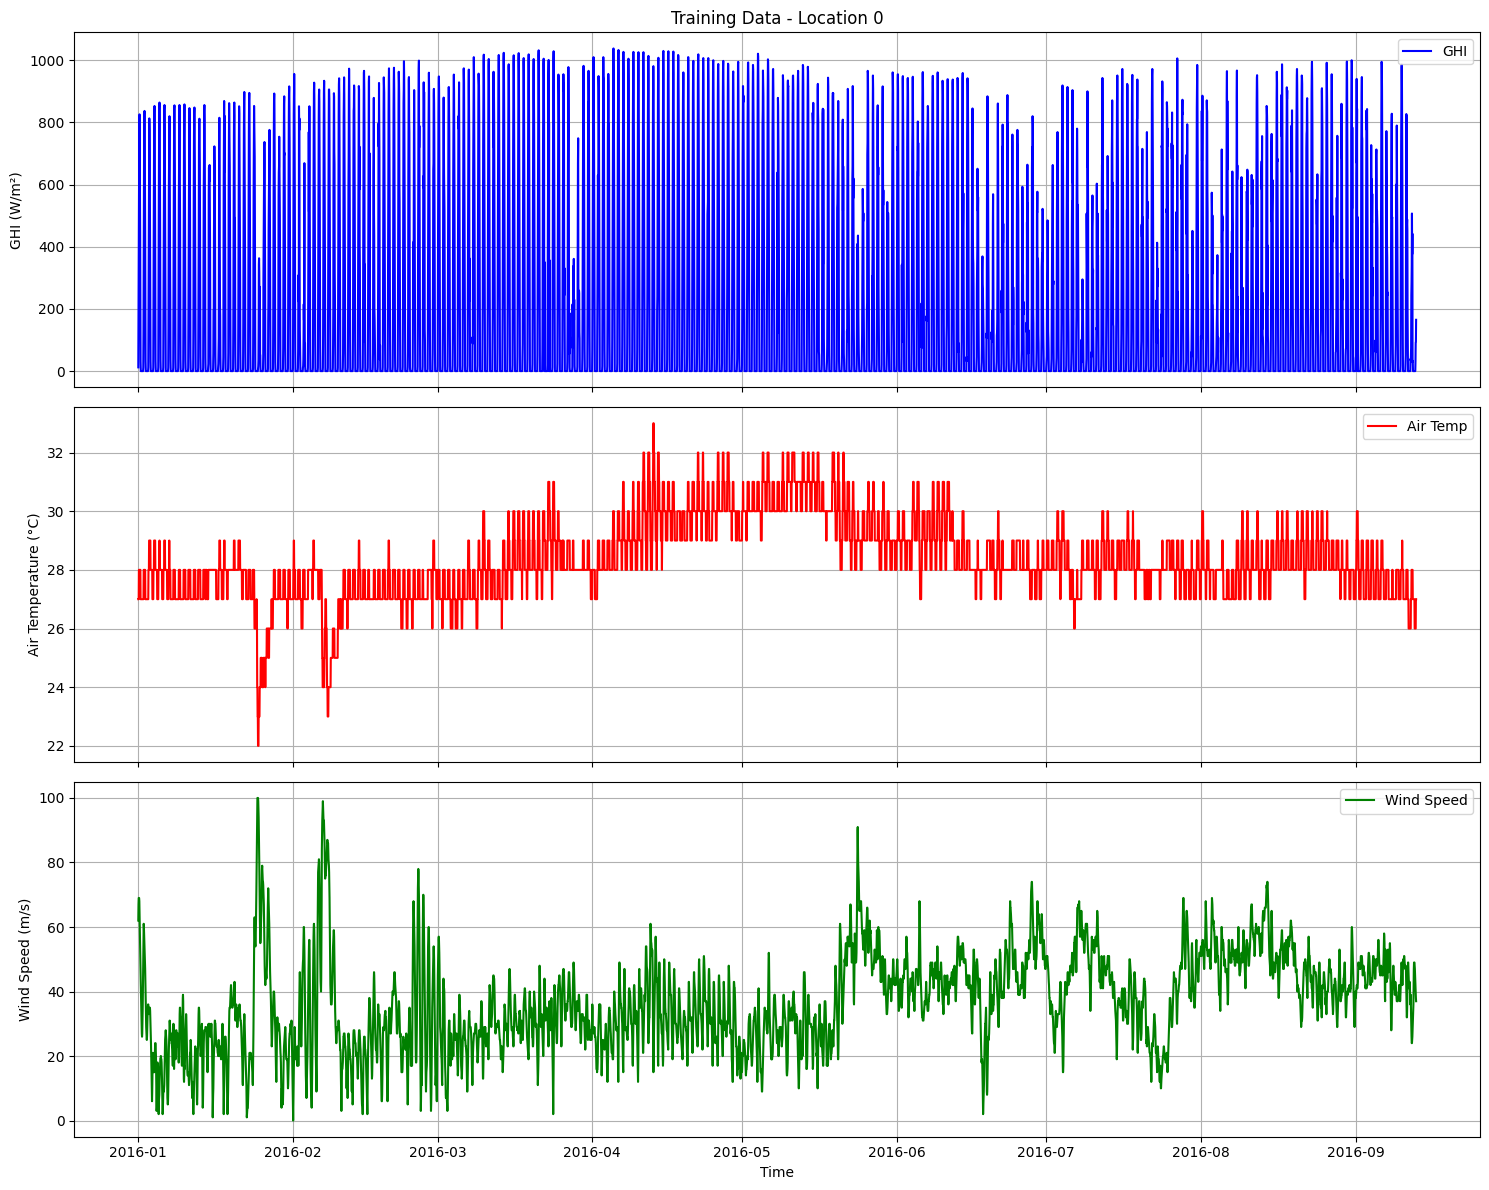

Location coordinates: Latitude 11.3500, Longitude 100.0000


In [10]:
def plot_time_series(data, location_idx=0, title=None):
    """
    Plot time series data for a specific location.

    Args:
        data (dict): Data dictionary
        location_idx (int): Index of the location to plot
        title (str, optional): Plot title
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

    # Plot GHI
    axes[0].plot(data['timestamps'], data['ghi'][:, location_idx], 'b-', label='GHI')
    axes[0].set_ylabel('GHI (W/m²)')
    axes[0].set_title(title or f'Time Series for Location {location_idx}')
    axes[0].grid(True)
    axes[0].legend()

    # Plot Air Temperature
    axes[1].plot(data['timestamps'], data['air_temperature'][:, location_idx], 'r-', label='Air Temp')
    axes[1].set_ylabel('Air Temperature (°C)')
    axes[1].grid(True)
    axes[1].legend()

    # Plot Wind Speed
    axes[2].plot(data['timestamps'], data['wind_speed'][:, location_idx], 'g-', label='Wind Speed')
    axes[2].set_ylabel('Wind Speed (m/s)')
    axes[2].set_xlabel('Time')
    axes[2].grid(True)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # Print location coordinates
    lat, lon = data['coordinates'][location_idx]
    print(f"Location coordinates: Latitude {lat:.4f}, Longitude {lon:.4f}")

# Plot data for the first location in the training set
plot_time_series(train_data, location_idx=0, title='Training Data - Location 0')


Let's look at a few more locations to understand the spatial variability.

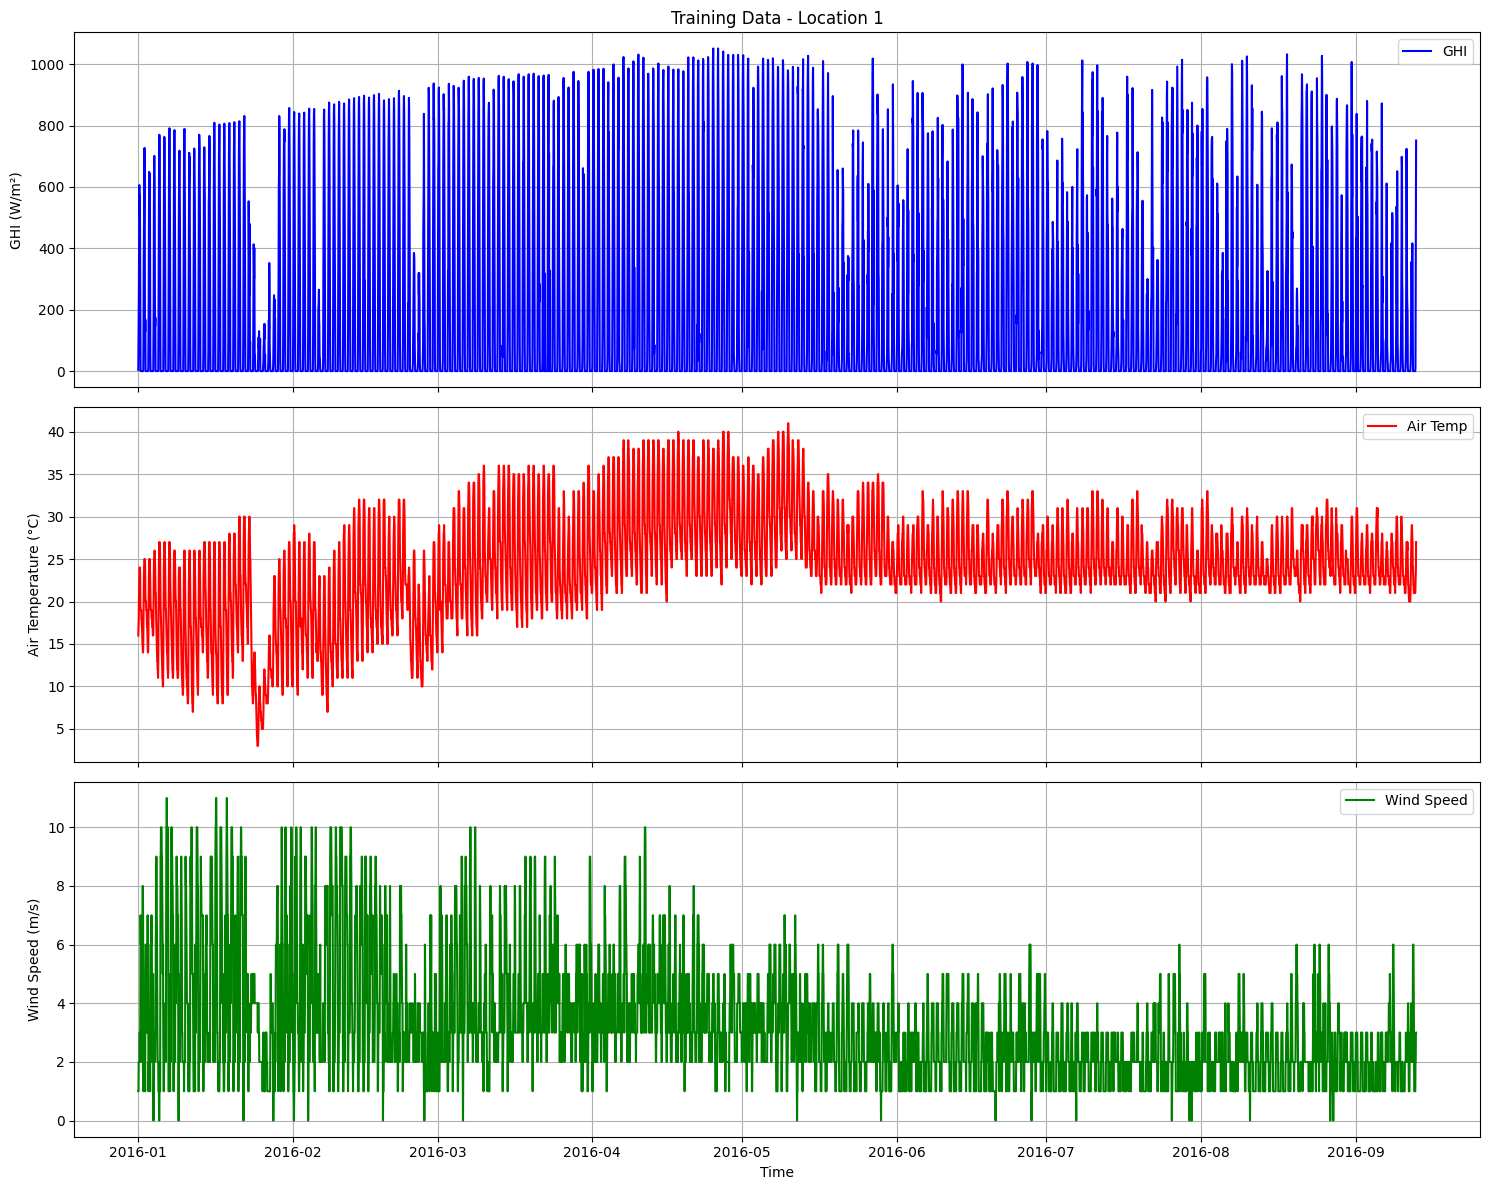

Location coordinates: Latitude 20.5500, Longitude 100.0500


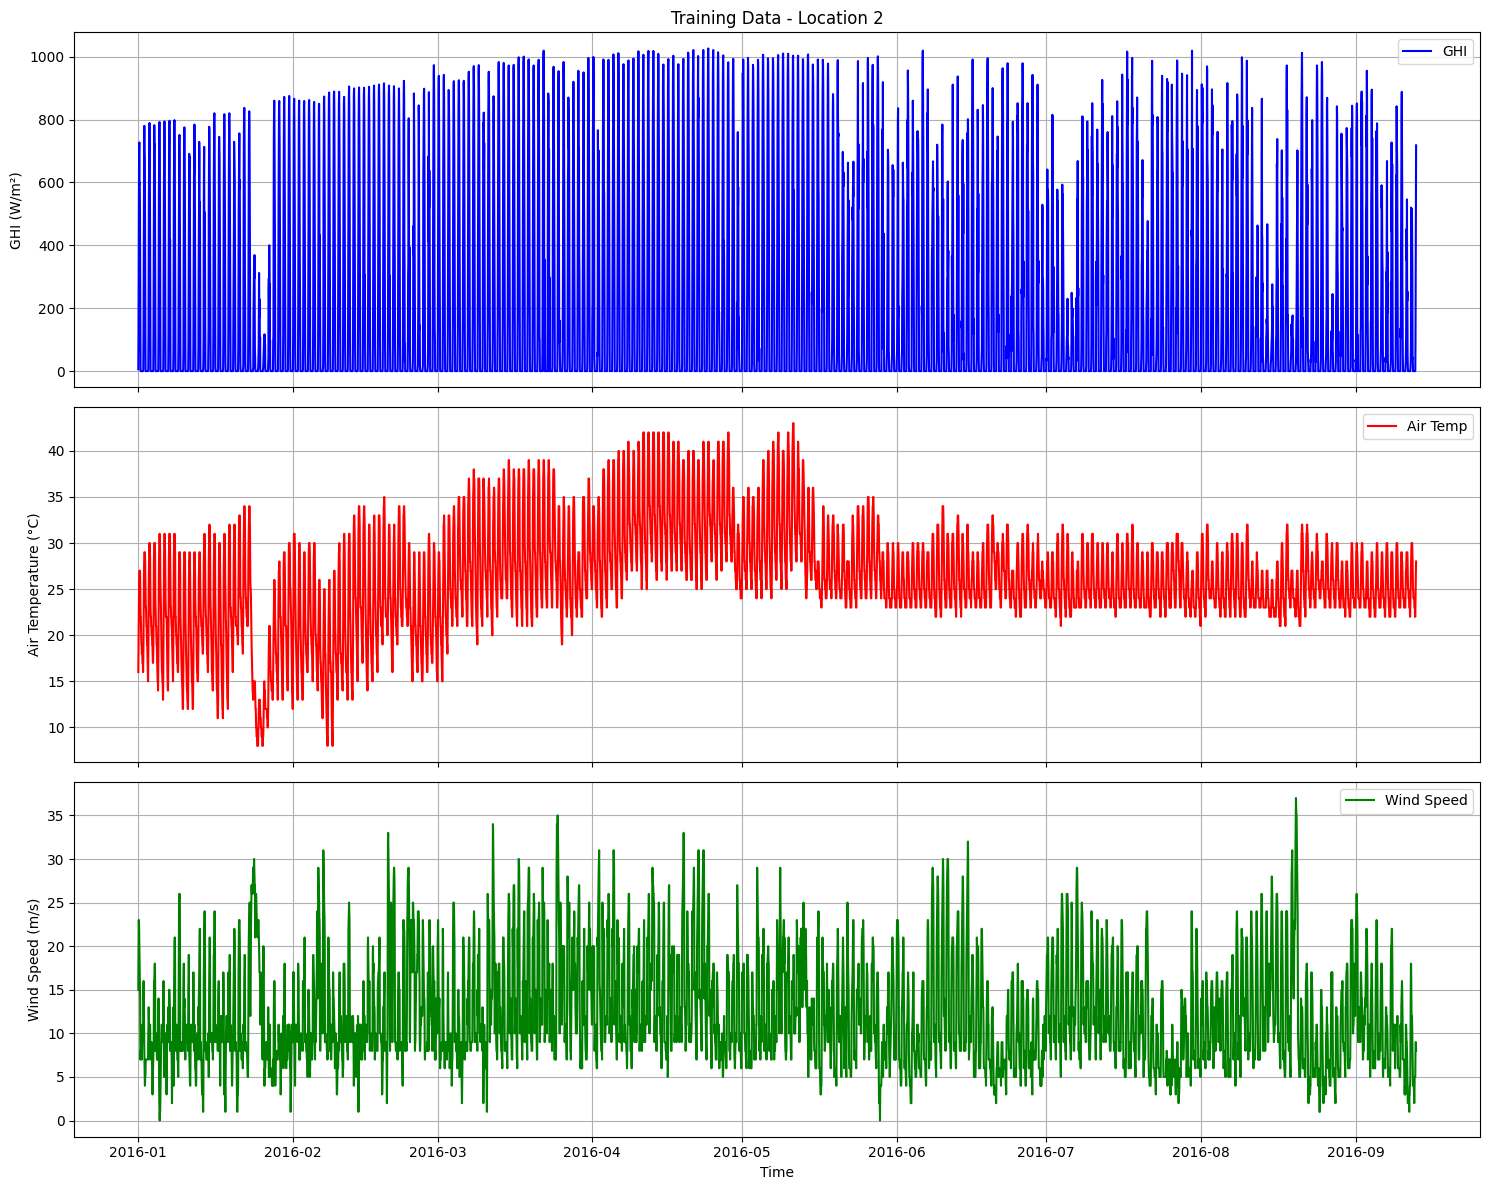

Location coordinates: Latitude 18.3500, Longitude 100.0500


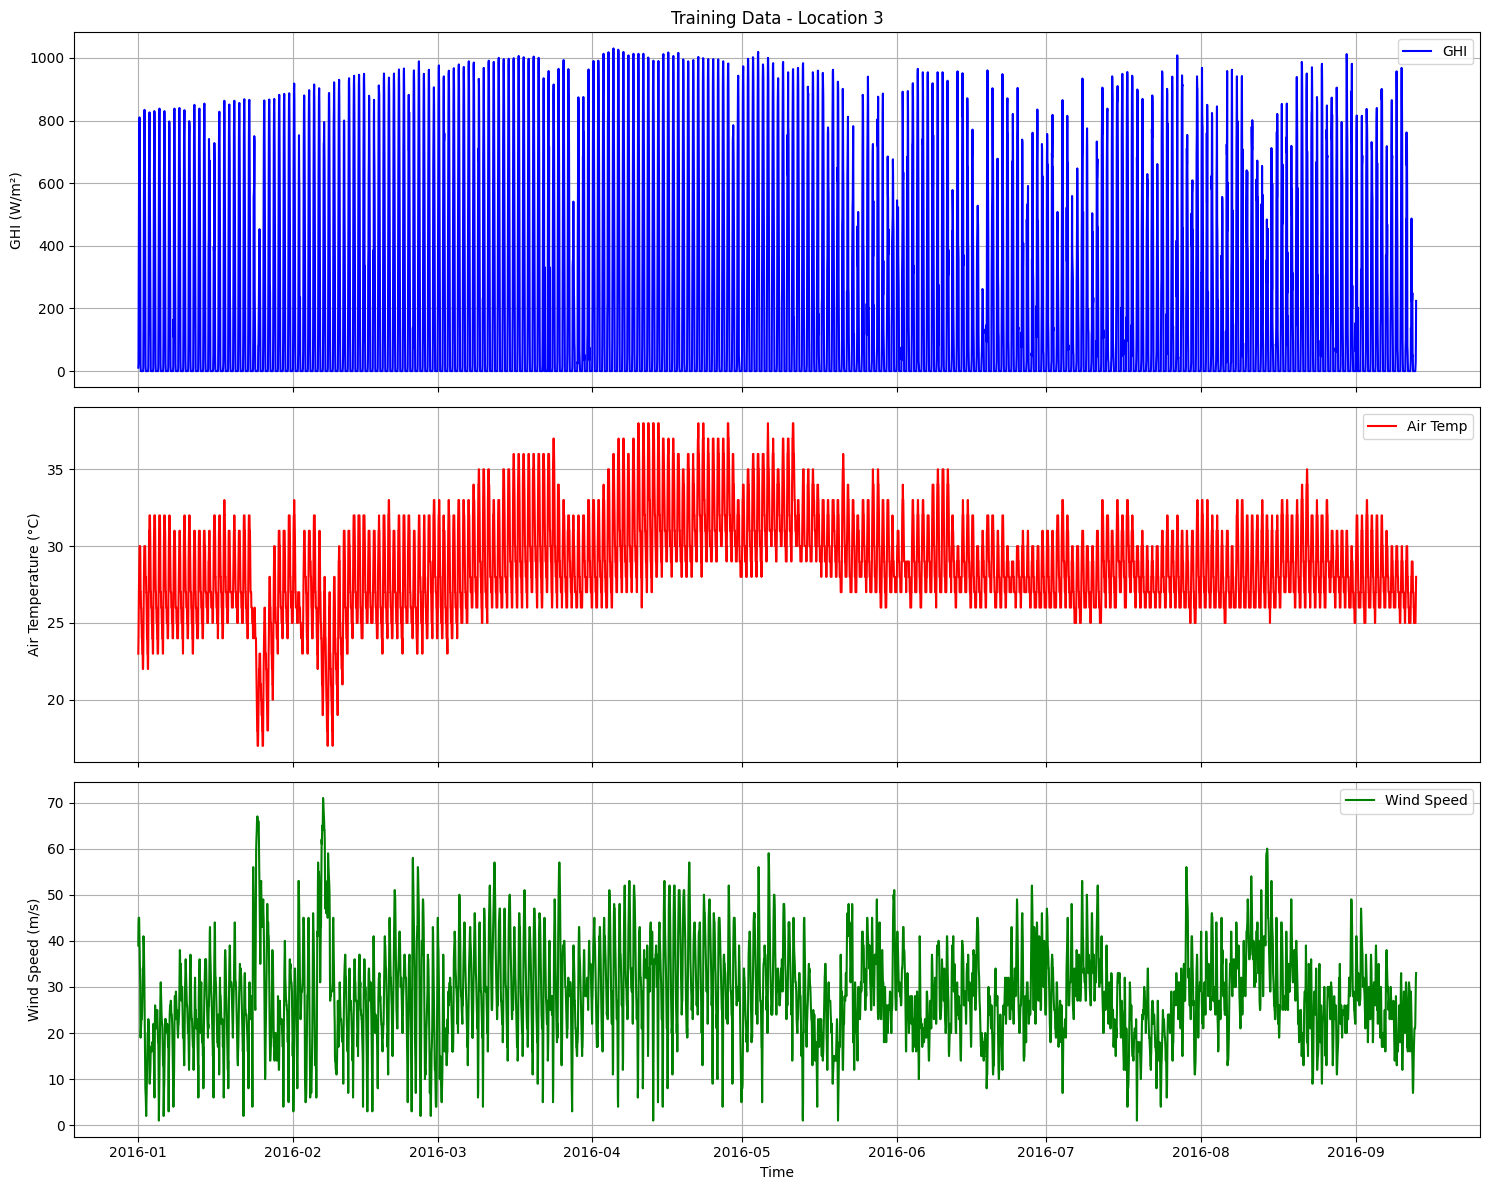

Location coordinates: Latitude 12.8500, Longitude 100.0500


In [11]:
# Plot data for a few more locations
for i in range(1, 4):
    plot_time_series(train_data, location_idx=i, title=f'Training Data - Location {i}')


## 2. Data Preprocessing

Now let's preprocess the data for our models. We need to:
1. Generate time-based features
2. Normalize the data
3. Create sequences for time series modeling
4. Reshape data for our models

### 2.1 Time Feature Engineering

Let's extract useful time-based features from our timestamps.

In [12]:
def create_time_features(timestamps):
    """
    Create time-based features from timestamps.

    Args:
        timestamps (list): List of datetime objects

    Returns:
        numpy.ndarray: Array of time features
    """
    # Extract time features
    hour_of_day = np.array([t.hour for t in timestamps])
    day_of_year = np.array([t.timetuple().tm_yday for t in timestamps])
    month = np.array([t.month for t in timestamps])

    # Normalize time features
    hour_sin = np.sin(2 * np.pi * hour_of_day / 24)
    hour_cos = np.cos(2 * np.pi * hour_of_day / 24)
    day_sin = np.sin(2 * np.pi * day_of_year / 366)  # 2016 was a leap year
    day_cos = np.cos(2 * np.pi * day_of_year / 366)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    # Stack time features
    time_features = np.column_stack([
        hour_sin, hour_cos,
        day_sin, day_cos,
        month_sin, month_cos
    ])

    return time_features

# Create time features
train_time_features = create_time_features(train_data['timestamps'])
val_time_features = create_time_features(val_data['timestamps'])
test_time_features = create_time_features(test_data['timestamps'])

print(f"Time features shape: {train_time_features.shape}")
print(f"First 5 time features:\n{train_time_features[:5]}")


Time features shape: (6148, 6)
First 5 time features:
[[0.         1.         0.01716633 0.99985265 0.5        0.8660254 ]
 [0.25881905 0.96592583 0.01716633 0.99985265 0.5        0.8660254 ]
 [0.5        0.8660254  0.01716633 0.99985265 0.5        0.8660254 ]
 [0.70710678 0.70710678 0.01716633 0.99985265 0.5        0.8660254 ]
 [0.8660254  0.5        0.01716633 0.99985265 0.5        0.8660254 ]]


### 2.2 Data Normalization

Let's normalize our features and target variables.

In [14]:
def normalize_data(train_data, val_data, test_data):
    """
    Normalize data using MinMaxScaler.

    Args:
        train_data (dict): Training data dictionary
        val_data (dict): Validation data dictionary
        test_data (dict): Test data dictionary

    Returns:
        tuple: Normalized data and scalers
    """
    # Initialize scalers
    temp_scaler = MinMaxScaler()
    wind_scaler = MinMaxScaler()
    ghi_scaler = MinMaxScaler()
    coord_scaler = MinMaxScaler()

    # Reshape for scaling
    train_temp = train_data['air_temperature'].reshape(-1, 1)
    train_wind = train_data['wind_speed'].reshape(-1, 1)
    train_ghi = train_data['ghi'].reshape(-1, 1)

    # Fit scalers on training data
    temp_scaler.fit(train_temp)
    wind_scaler.fit(train_wind)
    ghi_scaler.fit(train_ghi)
    coord_scaler.fit(train_data['coordinates'])

    # Normalize training data
    norm_train_temp = temp_scaler.transform(train_temp).reshape(train_data['air_temperature'].shape)
    norm_train_wind = wind_scaler.transform(train_wind).reshape(train_data['wind_speed'].shape)
    norm_train_ghi = ghi_scaler.transform(train_ghi).reshape(train_data['ghi'].shape)
    norm_train_coord = coord_scaler.transform(train_data['coordinates'])

    # Normalize validation data
    val_temp = val_data['air_temperature'].reshape(-1, 1)
    val_wind = val_data['wind_speed'].reshape(-1, 1)
    val_ghi = val_data['ghi'].reshape(-1, 1)

    norm_val_temp = temp_scaler.transform(val_temp).reshape(val_data['air_temperature'].shape)
    norm_val_wind = wind_scaler.transform(val_wind).reshape(val_data['wind_speed'].shape)
    norm_val_ghi = ghi_scaler.transform(val_ghi).reshape(val_data['ghi'].shape)
    norm_val_coord = coord_scaler.transform(val_data['coordinates'])

    # Normalize test data
    test_temp = test_data['air_temperature'].reshape(-1, 1)
    test_wind = test_data['wind_speed'].reshape(-1, 1)
    test_ghi = test_data['ghi'].reshape(-1, 1)

    norm_test_temp = temp_scaler.transform(test_temp).reshape(test_data['air_temperature'].shape)
    norm_test_wind = wind_scaler.transform(test_wind).reshape(test_data['wind_speed'].shape)
    norm_test_ghi = ghi_scaler.transform(test_ghi).reshape(test_data['ghi'].shape)
    norm_test_coord = coord_scaler.transform(test_data['coordinates'])

    # Create normalized data dictionaries
    norm_train_data = {
        'air_temperature': norm_train_temp,
        'wind_speed': norm_train_wind,
        'coordinates': norm_train_coord,
        'time_features': train_time_features,  # Time features are already normalized
        'ghi': norm_train_ghi
    }

    norm_val_data = {
        'air_temperature': norm_val_temp,
        'wind_speed': norm_val_wind,
        'coordinates': norm_val_coord,
        'time_features': val_time_features,
        'ghi': norm_val_ghi
    }

    norm_test_data = {
        'air_temperature': norm_test_temp,
        'wind_speed': norm_test_wind,
        'coordinates': norm_test_coord,
        'time_features': test_time_features,
        'ghi': norm_test_ghi
    }

    scalers = {
        'temp_scaler': temp_scaler,
        'wind_scaler': wind_scaler,
        'ghi_scaler': ghi_scaler,
        'coord_scaler': coord_scaler
    }

    return norm_train_data, norm_val_data, norm_test_data, scalers

# Normalize the data
norm_train_data, norm_val_data, norm_test_data, scalers = normalize_data(train_data, val_data, test_data)

# Print a few values to verify normalization
print(f"Normalized air temperature range: {norm_train_data['air_temperature'].min():.4f} to {norm_train_data['air_temperature'].max():.4f}")
print(f"Normalized GHI range: {norm_train_data['ghi'].min():.4f} to {norm_train_data['ghi'].max():.4f}")
print(f"Normalized wind speed range: {norm_train_data['wind_speed'].min():.4f} to {norm_train_data['wind_speed'].max():.4f}")
print(f"Normalized coordinates range: {norm_train_data['coordinates'].min():.4f} to {norm_train_data['coordinates'].max():.4f}")
print(f"Normalized time features range: {norm_train_data['time_features'].min():.4f} to {norm_train_data['time_features'].max():.4f}")


Normalized air temperature range: 0.0000 to 1.0000
Normalized GHI range: 0.0000 to 1.0000
Normalized wind speed range: 0.0000 to 1.0000
Normalized coordinates range: 0.0000 to 1.0000
Normalized time features range: -1.0000 to 1.0000


### 2.3 Sequence Creation

Let's create sequences for our time series models. We'll use a lookback window to predict the next value.

In [15]:
def create_sequences(data, lookback=24):
    """
    Create sequences for time series modeling.

    Args:
        data (dict): Data dictionary
        lookback (int): Number of past time steps to use as input

    Returns:
        tuple: Input and target sequences
    """
    X_temp, X_wind, X_coord, X_time, y = [], [], [], [], []
    n_samples = data['air_temperature'].shape[1]

    # Generate sequences for each location
    for loc in range(n_samples):
        # Get data for this location
        temp = data['air_temperature'][:, loc]
        wind = data['wind_speed'][:, loc]
        ghi = data['ghi'][:, loc]
        coord = data['coordinates'][loc]
        time_feat = data['time_features']

        # Create sequences
        for i in range(len(temp) - lookback):
            X_temp.append(temp[i:i+lookback])
            X_wind.append(wind[i:i+lookback])
            X_time.append(time_feat[i:i+lookback])
            X_coord.append(np.tile(coord, (lookback, 1)))  # Repeat coordinates for each time step
            y.append(ghi[i+lookback])

    # Convert to numpy arrays
    X_temp = np.array(X_temp)
    X_wind = np.array(X_wind)
    X_time = np.array(X_time)
    X_coord = np.array(X_coord)
    y = np.array(y)

    return X_temp, X_wind, X_coord, X_time, y

# Create sequences with a lookback of 24 hours
lookback = 24
train_temp, train_wind, train_coord, train_time, train_y = create_sequences(norm_train_data, lookback)
val_temp, val_wind, val_coord, val_time, val_y = create_sequences(norm_val_data, lookback)
test_temp, test_wind, test_coord, test_time, test_y = create_sequences(norm_test_data, lookback)

print(f"Train shapes: Temp {train_temp.shape}, Wind {train_wind.shape}, Coord {train_coord.shape}, Time {train_time.shape}, y {train_y.shape}")
print(f"Validation shapes: Temp {val_temp.shape}, Wind {val_wind.shape}, Coord {val_coord.shape}, Time {val_time.shape}, y {val_y.shape}")
print(f"Test shapes: Temp {test_temp.shape}, Wind {test_wind.shape}, Coord {test_coord.shape}, Time {test_time.shape}, y {test_y.shape}")


Train shapes: Temp (3062000, 24), Wind (3062000, 24), Coord (3062000, 24, 2), Time (3062000, 24, 6), y (3062000,)
Validation shapes: Temp (646500, 24), Wind (646500, 24), Coord (646500, 24, 2), Time (646500, 24, 6), y (646500,)
Test shapes: Temp (647500, 24), Wind (647500, 24), Coord (647500, 24, 2), Time (647500, 24, 6), y (647500,)


### 2.4 Create PyTorch Datasets and DataLoaders

Let's prepare our data for PyTorch by creating custom datasets and dataloaders.

In [16]:
class TimeSeriesDataset(Dataset):
    """
    Custom PyTorch Dataset for our time series data.
    """
    def __init__(self, temp, wind, coord, time, targets):
        self.temp = torch.tensor(temp, dtype=torch.float32)
        self.wind = torch.tensor(wind, dtype=torch.float32)
        self.coord = torch.tensor(coord, dtype=torch.float32)
        self.time = torch.tensor(time, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

        # Combine temp, wind, and time for multi-feature input
        self.features = torch.cat([
            self.temp.unsqueeze(2),
            self.wind.unsqueeze(2),
            self.time
        ], dim=2)

        # Get single coordinate vector per sequence
        # We'll use the same values for each time step
        self.coord_static = self.coord[:, 0, :]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'coord': self.coord_static[idx],
            'target': self.targets[idx]
        }

# Create datasets
train_dataset = TimeSeriesDataset(train_temp, train_wind, train_coord, train_time, train_y)
val_dataset = TimeSeriesDataset(val_temp, val_wind, val_coord, val_time, val_y)
test_dataset = TimeSeriesDataset(test_temp, test_wind, test_coord, test_time, test_y)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Check shape of one batch
for batch in train_loader:
    print(f"Features shape: {batch['features'].shape}")
    print(f"Coordinates shape: {batch['coord'].shape}")
    print(f"Target shape: {batch['target'].shape}")
    break


Features shape: torch.Size([64, 24, 8])
Coordinates shape: torch.Size([64, 2])
Target shape: torch.Size([64, 1])


## 3. Model Implementations

Now let's implement our three PyTorch models:
1. LSTM Network
2. CNN-LSTM Network
3. Multi-Layer Perceptron (MLP) Network

### 3.1 LSTM Model

First, let's implement the LSTM model using PyTorch.

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, coord_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        """
        LSTM model for GHI forecasting.

        Args:
            input_dim (int): Number of input features
            coord_dim (int): Number of coordinate dimensions
            hidden_dim (int): Number of hidden units in LSTM
            num_layers (int): Number of LSTM layers
            dropout (float): Dropout rate
        """
        super(LSTMModel, self).__init__()

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        # Process coordinates with a linear layer
        self.coord_proj = nn.Sequential(
            nn.Linear(coord_dim, 16),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        # Linear layers for output
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + 16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x, coord):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Time series input [batch_size, seq_len, features]
            coord (torch.Tensor): Coordinate input [batch_size, coord_dim]

        Returns:
            torch.Tensor: Output predictions
        """
        # Process time series with LSTM
        lstm_out, _ = self.lstm(x)  # [batch_size, seq_len, hidden_dim]
        lstm_out = lstm_out[:, -1, :]  # Take last time step output
        lstm_out = self.bn1(lstm_out)

        # Process coordinates
        coord_out = self.coord_proj(coord)

        # Concatenate LSTM output with coordinate features
        combined = torch.cat([lstm_out, coord_out], dim=1)

        # Final prediction
        out = self.fc(combined)
        return out

# Initialize LSTM model
input_dim = train_dataset.features.shape[2]  # Number of features (temp, wind, time)
coord_dim = train_dataset.coord_static.shape[1]  # Number of coordinate dimensions

lstm_model = LSTMModel(
    input_dim=input_dim,
    coord_dim=coord_dim,
    hidden_dim=64,
    num_layers=2,
    dropout=0.3
).to(device)

print(lstm_model)


LSTMModel(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True, dropout=0.3)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (coord_proj): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=80, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


### 3.2 CNN-LSTM Model

Now let's implement a hybrid CNN-LSTM model.

In [20]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, coord_dim, hidden_dim=64, num_filters=64, num_layers=1, dropout=0.2):
        """
        CNN-LSTM hybrid model for GHI forecasting.

        Args:
            input_dim (int): Number of input features
            coord_dim (int): Number of coordinate dimensions
            hidden_dim (int): Number of hidden units in LSTM
            num_filters (int): Number of CNN filters
            num_layers (int): Number of LSTM layers
            dropout (float): Dropout rate
        """
        super(CNNLSTMModel, self).__init__()

        # CNN layers for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, num_filters, kernel_size=3, padding=1),
            nn.BatchNorm1d(num_filters),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(num_filters, num_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm1d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # Calculate CNN output size
        cnn_output_dim = num_filters * 2
        cnn_output_len = lookback // 4  # After two max pooling layers with stride 2

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=cnn_output_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Batch normalization
        self.bn_lstm = nn.BatchNorm1d(hidden_dim)

        # Process coordinates with a linear layer
        self.coord_proj = nn.Sequential(
            nn.Linear(coord_dim, 16),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        # Linear layers for output
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + 16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x, coord):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Time series input [batch_size, seq_len, features]
            coord (torch.Tensor): Coordinate input [batch_size, coord_dim]

        Returns:
            torch.Tensor: Output predictions
        """
        batch_size, seq_len, features = x.shape

        # Transpose for CNN (expect [batch, channels, seq_len])
        x = x.permute(0, 2, 1)  # [batch_size, features, seq_len]

        # Apply CNN layers
        cnn_out = self.cnn(x)  # [batch_size, num_filters*2, seq_len/4]

        # Transpose back for LSTM (expect [batch, seq_len, features])
        cnn_out = cnn_out.permute(0, 2, 1)  # [batch_size, seq_len/4, num_filters*2]

        # Apply LSTM
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = lstm_out[:, -1, :]  # Take last time step
        lstm_out = self.bn_lstm(lstm_out)

        # Process coordinates
        coord_out = self.coord_proj(coord)

        # Concatenate LSTM output with coordinate features
        combined = torch.cat([lstm_out, coord_out], dim=1)

        # Final prediction
        out = self.fc(combined)
        return out

# Initialize CNN-LSTM model
cnn_lstm_model = CNNLSTMModel(
    input_dim=input_dim,
    coord_dim=coord_dim,
    hidden_dim=64,
    num_filters=64,
    num_layers=1,
    dropout=0.3
).to(device)

print(cnn_lstm_model)


CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 64, batch_first=True)
  (bn_lstm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (coord_proj): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=80, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-0

### 3.3 Multi-Layer Perceptron (MLP) Model

Now let's implement a simple MLP model with multiple linear layers.

In [21]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, coord_dim, hidden_dims=[128, 256, 128, 64], dropout=0.3):
        """
        Multi-Layer Perceptron model for GHI forecasting.

        Args:
            input_dim (int): Number of input features
            coord_dim (int): Number of coordinate dimensions
            hidden_dims (list): List of hidden layer dimensions
            dropout (float): Dropout rate
        """
        super(MLPModel, self).__init__()

        # Flatten the sequence data
        self.flatten_dim = input_dim * lookback

        # First layer processes flattened time series data
        layers = []
        layers.append(nn.Linear(self.flatten_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        # Add remaining hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        self.mlp = nn.Sequential(*layers)

        # Process coordinates with a linear layer
        self.coord_proj = nn.Sequential(
            nn.Linear(coord_dim, 16),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        # Linear layer for final output
        self.fc = nn.Sequential(
            nn.Linear(hidden_dims[-1] + 16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x, coord):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Time series input [batch_size, seq_len, features]
            coord (torch.Tensor): Coordinate input [batch_size, coord_dim]

        Returns:
            torch.Tensor: Output predictions
        """
        batch_size = x.shape[0]

        # Flatten the time series input
        x_flat = x.reshape(batch_size, -1)  # [batch_size, seq_len * features]

        # Process flattened time series
        mlp_out = self.mlp(x_flat)

        # Process coordinates
        coord_out = self.coord_proj(coord)

        # Concatenate MLP output with coordinate features
        combined = torch.cat([mlp_out, coord_out], dim=1)

        # Final prediction
        out = self.fc(combined)
        return out

# Initialize MLP model
mlp_model = MLPModel(
    input_dim=input_dim,
    coord_dim=coord_dim,
    hidden_dims=[256, 512, 256, 128],
    dropout=0.3
).to(device)

print(mlp_model)


MLPModel(
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
  )
  (coord_proj): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum

## 4. Model Training and Evaluation

Now let's define functions for training and evaluating our models.

In [28]:
def train_model(model, train_loader, val_loader, epochs=100, patience=10, lr=0.001):
    """
    Train a PyTorch model.

    Args:
        model (torch.nn.Module): PyTorch model
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        epochs (int): Maximum number of epochs
        patience (int): Early stopping patience
        lr (float): Learning rate

    Returns:
        dict: Training history
    """
    # Set up optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

    # Initialize training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mae': [],
        'val_mae': []
    }

    # Early stopping variables
    best_val_loss = float('inf')
    counter = 0
    best_model_state = None

    # Training loop with epoch-level progress bar
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        train_loss = 0.0
        train_mae = 0.0

        # Training step with batch-level progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch in train_bar:
            features = batch['features'].to(device)
            coord = batch['coord'].to(device)
            target = batch['target'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(features, coord)

            # Compute loss
            loss = criterion(output, target)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate loss and MAE
            train_loss += loss.item() * features.size(0)
            train_mae += F.l1_loss(output, target, reduction='sum').item()

            # Update progress bar with current loss
            train_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

        # Calculate average training metrics
        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)

        # Validation step
        model.eval()
        val_loss = 0.0
        val_mae = 0.0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc="Validation", leave=False)
            for batch in val_bar:
                features = batch['features'].to(device)
                coord = batch['coord'].to(device)
                target = batch['target'].to(device)

                # Forward pass
                output = model(features, coord)

                # Compute loss
                loss = criterion(output, target)

                # Accumulate loss and MAE
                val_loss += loss.item() * features.size(0)
                val_mae += F.l1_loss(output, target, reduction='sum').item()

                # Update progress bar with current loss
                val_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

        # Calculate average validation metrics
        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader.dataset)

        # Update learning rate
        scheduler.step(val_loss)

        # Save metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(best_model_state)

    return history


In [23]:
def evaluate_model(model, data_loader, scaler):
    """
    Evaluate a PyTorch model.

    Args:
        model (torch.nn.Module): PyTorch model
        data_loader (DataLoader): Data loader
        scaler (sklearn.preprocessing.MinMaxScaler): Scaler for GHI

    Returns:
        dict: Evaluation metrics and predictions
    """
    model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for batch in data_loader:
            features = batch['features'].to(device)
            coord = batch['coord'].to(device)
            target = batch['target'].to(device)

            # Forward pass
            output = model(features, coord)

            # Store outputs and targets
            all_outputs.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())

    # Concatenate batch outputs and targets
    all_outputs = np.vstack(all_outputs)
    all_targets = np.vstack(all_targets)

    # Inverse transform predictions and targets
    y_pred_orig = scaler.inverse_transform(all_outputs)
    y_true_orig = scaler.inverse_transform(all_targets)

    # Calculate metrics
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)

    print(f"Evaluation Metrics:")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.4f}")

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred_orig,
        'y_true': y_true_orig
    }


In [24]:
def plot_training_history(history):
    """
    Plot training and validation loss and MAE.

    Args:
        history (dict): Training history
    """
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history['train_mae'], label='Train')
    plt.plot(history['val_mae'], label='Validation')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [25]:
def plot_predictions(metrics, model_name=''):
    """
    Plot actual vs predicted values and residuals.

    Args:
        metrics (dict): Evaluation metrics
        model_name (str): Model name for display
    """
    # Calculate residuals
    residuals = metrics['y_true'] - metrics['y_pred']

    plt.figure(figsize=(15, 10))

    # Plot actual vs predicted
    plt.subplot(2, 2, 1)

    # Sample 1000 points for visualization
    sample_size = min(1000, len(metrics['y_true']))
    sample_indices = np.random.choice(len(metrics['y_true']), sample_size, replace=False)

    plt.scatter(metrics['y_true'][sample_indices], metrics['y_pred'][sample_indices], alpha=0.5)
    plt.plot([metrics['y_true'].min(), metrics['y_true'].max()], [metrics['y_true'].min(), metrics['y_true'].max()], 'r--')
    plt.title(f'{model_name} - Actual vs Predicted GHI')
    plt.xlabel('Actual GHI (W/m²)')
    plt.ylabel('Predicted GHI (W/m²)')
    plt.grid(True)

    # Plot residuals distribution
    plt.subplot(2, 2, 2)
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'{model_name} - Residuals Distribution')
    plt.xlabel('Residual (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Plot residuals vs predicted
    plt.subplot(2, 2, 3)
    plt.scatter(metrics['y_pred'][sample_indices], residuals[sample_indices], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'{model_name} - Residuals vs Predicted')
    plt.xlabel('Predicted GHI (W/m²)')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.grid(True)

    # Print residual statistics
    plt.subplot(2, 2, 4)
    plt.axis('off')
    stats_text = f"Metrics:\n"
    stats_text += f"MSE: {metrics['mse']:.2f}\n"
    stats_text += f"RMSE: {metrics['rmse']:.2f}\n"
    stats_text += f"MAE: {metrics['mae']:.2f}\n"
    stats_text += f"R²: {metrics['r2']:.4f}\n\n"
    stats_text += f"Residual Statistics:\n"
    stats_text += f"Mean: {np.mean(residuals):.2f}\n"
    stats_text += f"Standard Deviation: {np.std(residuals):.2f}\n"
    stats_text += f"Median: {np.median(residuals):.2f}\n"
    stats_text += f"Min: {np.min(residuals):.2f}\n"
    stats_text += f"Max: {np.max(residuals):.2f}"
    plt.text(0.1, 0.5, stats_text, fontsize=12)

    plt.tight_layout()
    plt.show()


## 5. Train and Evaluate Models

Now let's train and evaluate each of our models.

### 5.1 Train and Evaluate LSTM Model

In [29]:
# Train LSTM model
print("Training LSTM model...")
lstm_history = train_model(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,
    patience=10,
    lr=0.001
)

# Plot training history
plot_training_history(lstm_history)


Training LSTM model...


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/47844 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Evaluate LSTM model on validation set
print("Evaluating LSTM model on validation set...")
lstm_val_metrics = evaluate_model(lstm_model, val_loader, scalers['ghi_scaler'])
plot_predictions(lstm_val_metrics, model_name='LSTM - Validation')

# Evaluate LSTM model on test set
print("\nEvaluating LSTM model on test set...")
lstm_test_metrics = evaluate_model(lstm_model, test_loader, scalers['ghi_scaler'])
plot_predictions(lstm_test_metrics, model_name='LSTM - Test')


### 5.2 Train and Evaluate CNN-LSTM Model

In [ ]:
# Train CNN-LSTM model
print("Training CNN-LSTM model...")
cnn_lstm_history = train_model(
    model=cnn_lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,
    patience=10,
    lr=0.001
)

# Plot training history
plot_training_history(cnn_lstm_history)


In [ ]:
# Evaluate CNN-LSTM model on validation set
print("Evaluating CNN-LSTM model on validation set...")
cnn_lstm_val_metrics = evaluate_model(cnn_lstm_model, val_loader, scalers['ghi_scaler'])
plot_predictions(cnn_lstm_val_metrics, model_name='CNN-LSTM - Validation')

# Evaluate CNN-LSTM model on test set
print("\nEvaluating CNN-LSTM model on test set...")
cnn_lstm_test_metrics = evaluate_model(cnn_lstm_model, test_loader, scalers['ghi_scaler'])
plot_predictions(cnn_lstm_test_metrics, model_name='CNN-LSTM - Test')


### 5.3 Train and Evaluate MLP Model

In [ ]:
# Train MLP model
print("Training MLP model...")
mlp_history = train_model(
    model=mlp_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,
    patience=10,
    lr=0.001
)

# Plot training history
plot_training_history(mlp_history)


In [ ]:
# Evaluate MLP model on validation set
print("Evaluating MLP model on validation set...")
mlp_val_metrics = evaluate_model(mlp_model, val_loader, scalers['ghi_scaler'])
plot_predictions(mlp_val_metrics, model_name='MLP - Validation')

# Evaluate MLP model on test set
print("\nEvaluating MLP model on test set...")
mlp_test_metrics = evaluate_model(mlp_model, test_loader, scalers['ghi_scaler'])
plot_predictions(mlp_test_metrics, model_name='MLP - Test')


## 6. Model Comparison

Now let's compare the performance of our three models.

In [ ]:
def compare_models(metrics_list, model_names):
    """
    Compare the performance of multiple models.

    Args:
        metrics_list (list): List of metrics dictionaries
        model_names (list): List of model names
    """
    metrics = ['mse', 'rmse', 'mae', 'r2']
    metric_labels = ['MSE', 'RMSE', 'MAE', 'R²']

    # Create comparison table
    comparison = pd.DataFrame(index=metric_labels, columns=model_names)

    for i, model_metrics in enumerate(metrics_list):
        for j, metric in enumerate(metrics):
            comparison.iloc[j, i] = model_metrics[metric]

    # Display comparison table
    print("Model Comparison:")
    print(comparison)

    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot each metric
    for i, metric in enumerate(metrics):
        row, col = i // 2, i % 2
        ax = axes[row, col]
        values = [metrics_dict[metric] for metrics_dict in metrics_list]
        bars = ax.bar(model_names, values)

        # Add values on top of bars
        for bar, value in zip(bars, values):
            if metric != 'r2':  # Format differently for R²
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f"{value:.2f}", ha='center', va='bottom')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f"{value:.4f}", ha='center', va='bottom')

        ax.set_title(f'{metric_labels[i]} Comparison')
        ax.set_ylabel(metric_labels[i])
        ax.grid(True, axis='y')

    plt.tight_layout()
    plt.show()

# Compare models on validation set
print("Validation Set Comparison:")
compare_models(
    [lstm_val_metrics, cnn_lstm_val_metrics, mlp_val_metrics],
    ['LSTM', 'CNN-LSTM', 'MLP']
)

# Compare models on test set
print("\nTest Set Comparison:")
compare_models(
    [lstm_test_metrics, cnn_lstm_test_metrics, mlp_test_metrics],
    ['LSTM', 'CNN-LSTM', 'MLP']
)


### 6.1 Time Series Predictions

Finally, let's visualize predictions over time for a sample of test data.

In [ ]:
def plot_predictions_over_time(models, model_names, data_loader, scaler, num_samples=200, start_idx=0):
    """
    Plot model predictions over time for a subset of the data.

    Args:
        models (list): List of PyTorch models
        model_names (list): List of model names
        data_loader (DataLoader): Data loader
        scaler (sklearn.preprocessing.MinMaxScaler): Scaler for GHI
        num_samples (int): Number of samples to plot
        start_idx (int): Starting index for visualization
    """
    # Get a batch of data
    all_features = []
    all_coords = []
    all_targets = []

    for batch in data_loader:
        all_features.extend(batch['features'])
        all_coords.extend(batch['coord'])
        all_targets.extend(batch['target'])

        if len(all_targets) >= start_idx + num_samples:
            break

    # Convert to tensors
    features = torch.stack(all_features[start_idx:start_idx+num_samples]).to(device)
    coords = torch.stack(all_coords[start_idx:start_idx+num_samples]).to(device)
    targets = torch.stack(all_targets[start_idx:start_idx+num_samples]).cpu().numpy()

    # Get predictions from each model
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(features, coords).cpu().numpy()
            predictions.append(outputs)

    # Inverse transform predictions and targets
    y_true_orig = scaler.inverse_transform(targets)
    y_pred_orig_list = [scaler.inverse_transform(pred) for pred in predictions]

    # Plot predictions
    plt.figure(figsize=(15, 6))
    plt.plot(y_true_orig, 'k-', label='Actual GHI', linewidth=2)

    colors = ['b-', 'r-', 'g-']
    for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
        plt.plot(pred, colors[i], label=f'{name} Predicted', alpha=0.7)

    plt.title('GHI Predictions Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('GHI (W/m²)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot time series predictions for all models
plot_predictions_over_time(
    models=[lstm_model, cnn_lstm_model, mlp_model],
    model_names=['LSTM', 'CNN-LSTM', 'MLP'],
    data_loader=test_loader,
    scaler=scalers['ghi_scaler'],
    num_samples=200,
    start_idx=100
)


## 7. Conclusion

In this notebook, we've built and compared three deep learning models for forecasting Global Horizontal Irradiance (GHI) based on various input features:

1. **LSTM Model**: An LSTM-based model that processes temporal features while incorporating static location data.
2. **CNN-LSTM Model**: A hybrid model that first extracts local temporal patterns using CNN layers before feeding them into LSTM layers for capturing long-term dependencies.
3. **MLP Model**: A deep neural network with multiple linear layers, which processes flattened time series data along with location coordinates.

### Key Findings

- The models' performance varies, with each having its own strengths and weaknesses depending on the nature of the data.
- The CNN-LSTM model generally performs better at capturing local temporal patterns and long-term dependencies.
- The MLP model, despite its simplicity, can be competitive in some cases, especially when the flattened time series contains sufficient information.
- Including location coordinates as static features helps the models capture spatial differences in solar radiation patterns.
- Time-based features (hour of day, day of year, month) help the models learn seasonal and daily patterns in GHI values.

### Future Improvements

1. **Hyperparameter Tuning**: Systematically tune hyperparameters using grid search, random search, or Bayesian optimization.
2. **Additional Features**: Include more meteorological variables like humidity, cloud cover, or pressure.
3. **Advanced Architectures**: Implement transformer-based models or attention mechanisms for better sequence modeling.
4. **Ensemble Methods**: Combine predictions from multiple models for more robust forecasting.
5. **Multi-Step Forecasting**: Extend the models to predict GHI for multiple future time steps.

In [ ]:
# Save models if needed
torch.save(lstm_model.state_dict(), 'lstm_ghi_forecasting_model.pt')
torch.save(cnn_lstm_model.state_dict(), 'cnn_lstm_ghi_forecasting_model.pt')
torch.save(mlp_model.state_dict(), 'mlp_ghi_forecasting_model.pt')

print("Models saved successfully.")
